# Planar simple shear

Relevant resources:
- Figure 5 in [Kaminski & Ribe, 2001](https://doi.org/10.1016%2Fs0012-821x%2801%2900356-9)
- Figure 3 in [Lev & Hager, 2008](https://doi.org/10.1029%2F2008gc002032)

## Pure olivine

Shear defined by

$$\frac{\partial v_{y}}{\partial x} = D_{0}$$

so that the active slip system is $(010)[100]$ as in [Zhang & Karato, 1995](https://doi.org/10.1038%2F375774a0).

**Unresolved**:
- [x] FSE calculation seems unstable or not resolved
    - *Fixed by using "ev" driver for scipy eigh and extracting the largest eigenvalue directly without applying a rotation*
- [ ] LSODA requires a somewhat arbitrary first_step to stop it from choosing a tiny timestep
- [ ] Starting with an initial condition of $\theta_{z} \in [0, 90]\degree$ changes the evolution, no longer matches FSE for $M^{\ast}=0$ (maybe this is expected, not enough "hard" grains for the correct evolution, this condition is very artificial and doesn't match the experimental setup)

**To-do**:
- [ ] Add M-index plots with inset histograms of the grain size distribution

In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

from pydrex import minerals as _minerals
from pydrex import deformation_mechanism as _defmech
from pydrex import diagnostics as _diagnostics
from pydrex import stats as _stats
from pydrex import logger as _log

In [2]:
# Set up parameters
n_grains = 3000
gbm_mobilities = [0, 50, 200]
params = {
    "olivine_fraction": 1,
    "stress_exponent": 3.5,
    "deformation_exponent": 1.5,
    "gbs_threshold": 0.2,
    "nucleation_efficiency": 5,
    "number_of_grains": n_grains,
}

In [3]:
# Set up initial conditions
rng = np.random.default_rng(seed=8816)

deformation_gradient_init = np.eye(3)
# orientations_init = Rotation.from_rotvec(
#     [[0, 0, -θ * np.pi / 2] for θ in rng.random(n_grains)]
# ).as_matrix()
orientations_init = Rotation.random(n_grains).as_matrix()

def get_velocity_gradient(x):
    return np.array([[0, 0, 0], [2, 0, 0], [0, 0, 0]])

def get_position(t):
    return np.zeros(3)

def create_mineral():
    return _minerals.Mineral(
        _minerals.MineralPhase.olivine,
        _minerals.OlivineFabric.A,
        _defmech.Regime.dislocation,
        n_grains=n_grains,
        fractions_init=np.full(n_grains, 1 / n_grains),
        orientations_init=orientations_init,
    )

In [4]:
# Compute CPO and FSE angles for M* = {0, 50, 200}.
output = {
    "θ_fse_M0": [],
    "θ_fse_M50": [],
    "θ_fse_M200": [],
    "θ_cpo_M0": [],
    "θ_cpo_M50": [],
    "θ_cpo_M200": [],
    "timestamps": np.linspace(0, 1, 500),
}

for gbm_mobility in gbm_mobilities:
    params["gbm_mobility"] = gbm_mobility
    timestamps = output["timestamps"]
    θ_fse = np.empty_like(timestamps)
    θ_cpo = np.empty_like(timestamps)
    mineral = create_mineral()
    deformation_gradient = deformation_gradient_init.copy()
    θ_fse[0] = 45
    θ_cpo[0] = 45

    for t, time in enumerate(timestamps[1:], start=1):
        _log.info("calculating CPO at %s (t=%s)", [0, 0, 0], time)
        deformation_gradient = mineral.update_orientations(
            params,
            deformation_gradient,
            get_velocity_gradient,
            pathline=(timestamps[t-1], time, get_position),
        )

        # Compute FSE angle using principal strains.
        fse_λ, fse_v = la.eigh(
            deformation_gradient @ deformation_gradient.transpose(),
            driver="ev",
        )
        # λ3, λ2, λ1 = np.sqrt(fse_λ)
        # fse_orientation = Rotation.from_matrix(fse_v[:, ::-1])
        # θ_fse[t] = _diagnostics.smallest_angle(
        #     fse_orientation.apply([λ1, 0, 0]), [0, 1, 0]
        # )
        θ_fse[t] = _diagnostics.smallest_angle(
            fse_v[:, -1], [0, 1, 0]
        )

        # Compute CPO angle using Bingham average.
        orientations_resampled, _ = _stats.resample_orientations(
            mineral.orientations[-1], mineral.fractions[-1],
        )
        direction_mean = _diagnostics.bingham_average(
            orientations_resampled,
            axis=_minerals.OLIVINE_PRIMARY_AXIS[mineral.fabric],
        )
        θ_cpo[t] = _diagnostics.smallest_angle(
            direction_mean, [0, 1, 0]
        )

    _log.info("final deformation gradient: %s", deformation_gradient)
    output[f"θ_fse_M{int(gbm_mobility)}"] = θ_fse
    output[f"θ_cpo_M{int(gbm_mobility)}"] = θ_cpo

np.savez("planar_shear_mobility.npz", **output)

INFO [15:21] pydrex: created Mineral(phase=0, fabric=0, regime=1, n_grains=3000, fractions=<list of ndarray (3000,)>, orientations=<list of ndarray (3000, 3, 3)>)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.002004008016032064)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.004008016032064128)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.0060120240480961915)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.008016032064128256)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.01002004008016032)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.012024048096192383)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.014028056112224447)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.01603206412825651)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.018036072144288574)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.02004008016032064)
INFO [15:21] pydrex: calculating CPO at [0, 0, 0] (t=0.022044088176352703)
INFO [15:21] p

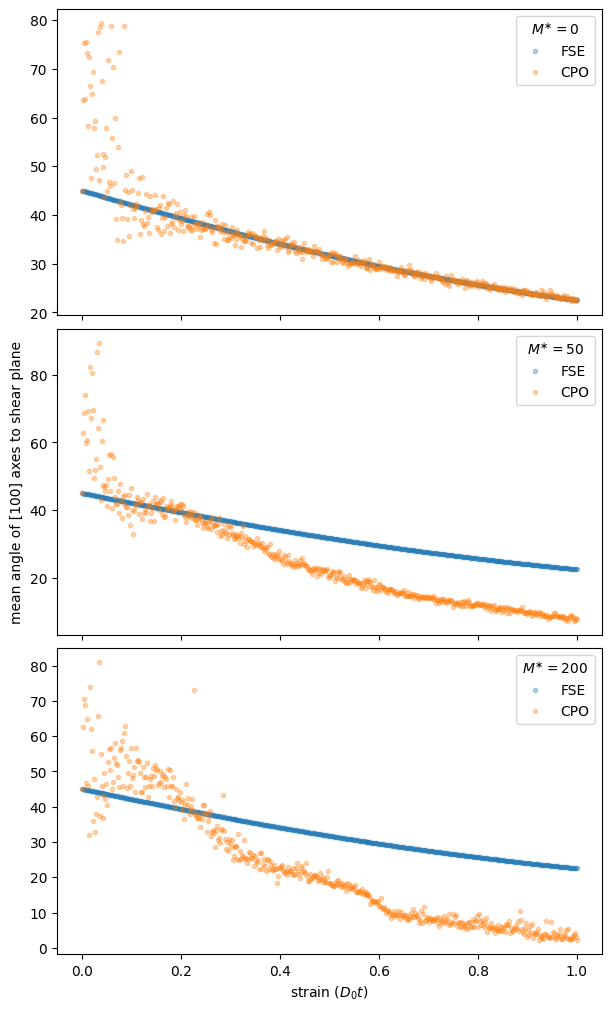

In [5]:
# Plot results.
fig = plt.figure(figsize=(6,10), constrained_layout=True)
ax0 = fig.add_subplot(3, 1, 1)
ax50 = fig.add_subplot(3, 1, 2, sharex=ax0)
ax200 = fig.add_subplot(3, 1, 3, sharex=ax0)

ax0.tick_params(labelbottom=False)
ax50.tick_params(labelbottom=False)
ax50.set_ylabel("mean angle of [100] axes to shear plane")
ax200.set_xlabel("strain ($D_{0}t$)")

for i, ax in enumerate((ax0, ax50, ax200)):
    gbm_mobility = int(gbm_mobilities[i])
    ax.plot(timestamps, output[f"θ_fse_M{gbm_mobility}"], ".", alpha=0.33, label="FSE")
    ax.plot(timestamps, output[f"θ_cpo_M{gbm_mobility}"], ".", alpha=0.33, label="CPO")
    ax.legend(title=fr"$M^{{\ast}}={{{gbm_mobility}}}$")